In [14]:
from library import StockUniverse, FactorLibrary, MarketInfo, FileLoader
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import gc
import torch
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
#from model import MASTER

In [2]:
FactorLibrary.multi_df

factor      factor_0                                              \
ticker          1101      1102      1103      1104          1108   
Date                                                               
2020-04-01 -0.204447  0.205286 -0.066181  0.698856  5.904405e+00   
2020-04-06  1.677682  2.064220  1.186552  2.021478  4.580153e+00   
2020-04-07  3.574125  6.542993  3.583062  3.932584  3.720238e+00   
2020-04-08  1.803156  3.897716  2.580645  3.086420  1.167883e+00   
2020-04-09  1.612903  2.657888  2.171137  2.251978  7.163324e-01   
...              ...       ...       ...       ...           ...   
2025-04-11  0.201748  1.637873  2.076125  0.662495  1.416853e+00   
2025-04-14  0.435949  0.178691  2.739726  1.645338  1.694915e+00   
2025-04-15 -1.298269 -1.757899 -0.539447 -1.377810  7.251632e-02   
2025-04-16 -1.143241 -0.826446 -0.473934 -0.693684 -7.267442e-02   
2025-04-17 -1.658768  0.044763  0.473613  0.365631 -2.664535e-13   

factor                                                            ...  \
ticker              1109      1110      1201      1203      1210  ...   
Date                                                              ...   
2020-04-01 -7.561437e-01 -1.967005  3.591879  0.800305  1.369863  ...   
2020-04-06  7.532957e-01 -2.742347  1.634321  0.190114  0.514766  ...   
2020-04-07  2.684145e+00 -1.923077  0.899101  0.720789  0.862999  ...   
2020-04-08  1.863354e+00 -0.388098  0.647733  0.830816  0.861837  ...   
2020-04-09  1.600985e+00  1.552393  1.045296  1.315789  1.099490  ...   
...                  ...       ...       ...       ...       ...  ...   
2025-04-11  1.234568e+00 -1.020987  0.555213  2.632279  1.587874  ...   
2025-04-14  2.932193e+00  2.362205  2.342787  1.968504  3.183119  ...   
2025-04-15  1.501502e+00  0.788288 -0.972053  0.388098  1.405975  ...   
2025-04-16  3.605769e-01 -0.113186 -1.098901 -0.438483  2.019499  ...   
2025-04-17  2.886580e-13 -1.352875 -0.674433 -0.438483  1.038062  ...   

factor     factor_185                                                    \
ticker           9944      9945      9946      9949      9950      9951   
Date                                                                      
2020-04-01   0.999935  0.993475  1.006718  0.995031  0.998105  1.000538   
2020-04-06   1.000702  0.993183  1.002554  1.001527  0.993129  1.001826   
2020-04-07   1.003852  1.000872  0.992585  0.999707  0.992867  1.003646   
2020-04-08   1.006097  1.000800  0.997986  0.999393  0.998528  1.004831   
2020-04-09   1.003150  1.000016  1.003579  1.001872  1.001097  1.003353   
...               ...       ...       ...       ...       ...       ...   
2025-04-11   0.996059  0.998892  0.995357  1.000269  0.997555  1.000148   
2025-04-14   1.001241  1.000427  0.996200  0.997938  0.994582  0.998891   
2025-04-15   0.998429  1.000944  1.001255  0.995323  0.999422  1.000020   
2025-04-16   0.999026  1.000255  1.005863  0.995549  1.001755  1.001636   
2025-04-17   1.002929  1.000698  1.004786  1.000000  0.997236  1.000412   

factor                                              
ticker          9955      9958      9960      9962  
Date                                                
2020-04-01  1.000069  1.000420  0.999717  0.998158  
2020-04-06  1.000605  0.999211  1.000621  1.000076  
2020-04-07  1.000810  0.999887  1.000332  1.003496  
2020-04-08  0.998951  1.002109  1.003819  1.003078  
2020-04-09  0.998678  1.000542  1.004274  0.998203  
...              ...       ...       ...       ...  
2025-04-11  0.998767  0.991700  1.004853  0.999544  
2025-04-14  0.998162  0.990563  0.996839  1.000758  
2025-04-15  0.999618  0.994872  0.996795  1.001954  
2025-04-16  1.003275  0.999744  0.999842  1.002569  
2025-04-17  1.001498  1.000800  0.997688  1.000966  

[1226 rows x 328667 columns]

# 下一步是依照TEST VALID TEST去劃分時間區段

In [3]:
class AllDayFactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE'):
        self.multi_df = FileLoader.load(f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')
        self.adj_close_df = pd.read_feather(r'Y:\因子回測_江建彰\補上缺值日頻收盤價.ftr')
        self.stock_list = self.get_stock_list(stock_universe)
        
        self.TPEX_df = MarketInfo.TPEX_norm()
        self.RoR_df = (self.adj_close_df.shift(-5) - self.adj_close_df.shift(-1)) / self.adj_close_df.shift(-1)
        self.RoR_df.dropna(axis=0, inplace=True)


        new_ticker_list = self.multi_df.columns.get_level_values('ticker')
        new_ticker_list = new_ticker_list[~new_ticker_list.duplicated()]

        self.stock_list = new_ticker_list
        self.RoR_df = self.RoR_df[self.stock_list]
        # 這裡所有值都包含當天資訊所以要向後移
        self.restrict_range()
        self.check_validility()

        


        

        #self.tensor_factor = self.factor_to_tensor()
        #self.tensor_market = self.TPEX_df.values
        #self.tensor_return = self.RoR_df[self.stock_list]
        #print(f'stock list : {len(self.stock_list)}')
    def check_validility(self):
        ticker_list1 = self.stock_list
        ticker_list2 = self.RoR_df.columns
        ticker_list3 = self.multi_df.columns.get_level_values('ticker')
        ticker_list3 = ticker_list3[~ticker_list3.duplicated()]
        assert len(ticker_list1)==len(ticker_list2)==len(ticker_list3)
        
        BOOL = True
        for i in range(len(ticker_list1)):
            if not (ticker_list1[i]==ticker_list2[i]==ticker_list3[i]):
                BOOL = False
        assert BOOL==True
        

        factor_list = self.multi_df.columns.get_level_values('factor')
        factor_list = factor_list[~factor_list.duplicated()]
        BOOL = True
        for factor_name in factor_list:
            ticker_list4 = self.multi_df.loc[ : , factor_name].columns
            for i in range(len(ticker_list1)):
                if ticker_list1[i]!=ticker_list4[i]:
                    BOOL = False
        assert BOOL==True
        

    def factor_to_tensor(self):
        factor_num = len(self.multi_df.columns.get_level_values('factor').unique())
        time = len(self.TPEX_df.index)
        

       
            
            
                
        """
        剔除因子缺失太多的股票
        
        new_stock_list = []
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = self.multi_df.xs(ticker, axis=1, level='ticker').values
            missing_ratio = np.isnan(numpy_array).sum() / (time*factor_num)
            if(missing_ratio<=0.05):
                new_stock_list.append(ticker)
        self.stock_list = new_stock_list
        """

        """
        轉成向量
        """

        
        factor_name = 'factor1'
        #print(self.multi_df.loc[start_date : end_date, factor_name])

        
        stock_num = len(self.stock_list)
        tensor_factor = np.empty((stock_num, time, factor_num))
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = self.multi_df.xs(ticker, axis=1, level='ticker').ffill().values
            numpy_array = np.nan_to_num(numpy_array, nan=0.0)
            tensor_factor[idx] = numpy_array

        
        
        return tensor_factor

    

    def restrict_range(self, global_start='2020-04-01', global_end='2025-04-09'):
        self.multi_df     = self.multi_df.loc[global_start : global_end]
        self.adj_close_df = self.adj_close_df.loc[global_start : global_end]
        self.TPEX_df      = self.TPEX_df.loc[global_start : global_end]
        self.RoR_df       = self.RoR_df.loc[global_start : global_end]
    
        
        
        
    def get_stock_list(self, stock_univserse):
        if stock_univserse=='TWSE':
            ticker1 = StockUniverse.TWSE() 
        elif stock_univserse=='OTC':
            ticker1 = StockUniverse.OTC()
        elif stock_univserse=='all':
            ticker1 = StockUniverse.all()
            
        
        ticker2 = self.multi_df.columns.get_level_values('ticker')
        ticker3 = self.adj_close_df.columns
        return list(set(ticker1)&set(ticker2)&set(ticker3))


    

In [4]:
class FactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE', mode='train'):
        #multi_df, TPEX_df, RoR_df = self.restrict_data_range(stock_universe, mode)
        self.e = AllDayFactorDataset(stock_universe='TWSE')
        self.stock_list = self.e.stock_list
        multi_df, TPEX_df, RoR_df = self.restrict_data_range(stock_universe, mode)

        
        
        self.tensor_factor = self.get_tensor_factors(multi_df)
        #self.tesnor_factor = self.tesnor_factor.transpose(1,0,2) # (stock, time, factor) -> (time, stock, factor)
        self.tensor_market = TPEX_df.values
        self.tensor_return = RoR_df.values

        self.tensor_factor = self.transform_to_tensor(self.tensor_factor)
        self.tensor_market = self.transform_to_tensor(self.tensor_market)
        self.tensor_return = self.transform_to_tensor(self.tensor_return)




        returns = self.tensor_return.clone()  # shape: [122, 887]
        mean = returns.mean(dim=1, keepdim=True)   # 每天的均值 shape: [122, 1]
        std = returns.std(dim=1, keepdim=True)     # 每天的標準差 shape: [122, 1]
        # 防止除以 0
        std = torch.where(std == 0, torch.tensor(1.0), std)
        self.tensor_return_norm = (returns - mean) / std  # shape: [122, 887]


        self.T = self.tensor_market.shape[0]
        self.lookback = 8
        self.valid_length = self.T - self.lookback

        del self.e
        gc.collect()
        
    def transform_to_tensor(self, numpy_array):
        float32_np = numpy_array.astype(np.float32)
        return torch.from_numpy(float32_np)

    def get_tensor_factors(self, multi_df):
        stock_num = len(multi_df.columns.get_level_values('ticker').unique())
        time = len(multi_df.index)
        factor_num = len(multi_df.columns.get_level_values('factor').unique())
        
        tensor_factor = np.empty((stock_num, time, factor_num))
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = multi_df.xs(ticker, axis=1, level='ticker').values
            tensor_factor[idx] = numpy_array

        assert not np.isnan(tensor_factor).any()

        return tensor_factor
        

    def restrict_data_range(self, stock_universe, mode):
        e = AllDayFactorDataset(stock_universe)
        train_ratio, valid_ratio, test_ratio = 0.8, 0.1, 0.1
        total_num = len(self.e.TPEX_df)
        train_num = int(total_num*train_ratio)
        valid_num = int(total_num*valid_ratio)
        test_num  = total_num - (train_num+valid_num)
        if mode=='train':
            start_idx, end_idx = 0, train_num
        elif mode=='valid':
            start_idx, end_idx = train_num, train_num + valid_num
        elif mode=='test': 
            start_idx, end_idx = train_num + valid_num, total_num

        e = AllDayFactorDataset(stock_universe)
        return self.e.multi_df.iloc[start_idx : end_idx], \
               self.e.TPEX_df.iloc[start_idx : end_idx], \
               self.e.RoR_df.iloc[start_idx : end_idx]
    def __len__(self):
        return self.valid_length
        
    def __getitem__(self, idx):
        X = self.tensor_factor[ : , idx:idx+self.lookback, : ] # (stock, time, factor)
        M = self.tensor_market[idx+self.lookback-1, : ]
        R = self.tensor_return[idx+self.lookback-1, : ]
        R_norm = self.tensor_return_norm[idx+self.lookback-1, : ]
        return X, M, R, R_norm
        

#t = FactorDataset(stock_universe='TWSE', mode='train')

In [5]:
#batch_size = 16 # 最原始
batch_size = 16

train_set = FactorDataset(stock_universe='TWSE', mode='train')
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valid_set = FactorDataset(stock_universe='TWSE', mode='valid')
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=True)
test_set = FactorDataset(stock_universe='TWSE', mode='test')
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

📂 讀取: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [6]:
train_set.tensor_return.shape

torch.Size([976, 887])

In [7]:
train_set.tensor_return_norm.shape

torch.Size([976, 887])

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from flash_attn import flash_attn_func







class MarketGuidedGating(nn.Module):
    def __init__(self, market_dim, feature_dim, beta=5):
        super().__init__()
        self.fc = nn.Linear(market_dim, feature_dim)
        nn.init.xavier_uniform_(self.fc.weight)  # 加這行
        nn.init.zeros_(self.fc.bias)             # 初始化 bias 為 0
        self.beta = beta
        self.feature_dim = feature_dim

    def forward(self, x, m):
        alpha = self.feature_dim * F.softmax(self.fc(m) / self.beta, dim=-1)
        #print("fc weight max:", self.fc.weight.max().item(), "min:", self.fc.weight.min().item())
        #print(self.fc(m))
        #print(m.max(), m.min())
        #print(torch.isnan(m.any()))
        #print(torch.isnan(self.fc(m)).any())
        
        #print(F.softmax(self.fc(m) / self.beta, dim=-1).sum(axis=1))
        #print(alpha.shape)
        #print(f'alpha : {alpha}')
        
        return x * alpha  # Hadamard product

class IntraStockEncoder(nn.Module):
    def __init__(self, feature_dim, embed_dim=256, nhead=4, max_len=60):
        super().__init__()
        self.input_proj = nn.Linear(feature_dim, embed_dim)#
        self.register_buffer('pos_encoder', self._get_sinusoid_encoding_table(max_len, embed_dim))#
        self.encoder_norm = nn.LayerNorm(embed_dim)#
        
        self.embed_dim = embed_dim#
        self.nhead = nhead#
        self.head_dim = embed_dim // nhead#
        assert self.head_dim * nhead == embed_dim, "embed_dim must be divisible by nhead"#
        
        
        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim) #
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.ReLU(),
            nn.Linear(4 * embed_dim, embed_dim),
        )

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        

    def forward(self, x):
        batch, time, _ = x.shape#
        x = self.input_proj(x)#
        #print(f'x.shape : {x.shape}')
        x = x + self.pos_encoder[:time, :].unsqueeze(0)#
        x = self.encoder_norm(x)#

        # QKV projection
        qkv = self.qkv_proj(x)  # (batch, time, 3*embed_dim) #
        qkv = qkv.view(batch, time, 3, self.nhead, self.head_dim) #
        q, k, v = qkv.unbind(dim=2)  # (batch, time, nhead, head_dim) #

        # Flash Attention
        attn_out = flash_attn_func(q, k, v, dropout_p=0.0, causal=False)  # (batch, time, nhead, head_dim)#
        attn_out = attn_out.view(batch, time, self.embed_dim)

        # Residual + Norm
        x = self.norm1(attn_out + x)

        # Feed Forward
        ffn_out = self.ffn(x)
        out = self.norm2(ffn_out + x)  # 注意這裡是再次 residual+norm

        return out

    def _get_sinusoid_encoding_table(self, seq_len, d_model):
        position = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

class InterStockAggregator(nn.Module):
    def __init__(self, embed_dim=256, nhead=2):
        super().__init__()
        self.embed_dim = embed_dim
        self.nhead = nhead
        self.head_dim = embed_dim // nhead
        assert self.head_dim * nhead == embed_dim, "embed_dim must be divisible by nhead"

        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.ReLU(),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        batch, stocks, time, embed_dim = x.shape#

        x_reshaped = x.permute(0, 2, 1, 3).reshape(batch * time, stocks, embed_dim)#

        qkv = self.qkv_proj(x_reshaped)
        qkv = qkv.view(batch * time, stocks, 3, self.nhead, self.head_dim)
        q, k, v = qkv.unbind(dim=2)

        attn_out = flash_attn_func(q, k, v, dropout_p=0.0, causal=False)
        attn_out = attn_out.reshape(batch * time, stocks, embed_dim)

        x_attn = self.norm1(attn_out + x_reshaped)
        ffn_out = self.ffn(x_attn)
        out = self.norm2(ffn_out + x_attn)

        out = out.view(batch, time, stocks, embed_dim).permute(0, 2, 1, 3)

        return out

class TemporalAggregator(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.w_lambda = nn.Parameter(torch.randn(embed_dim, embed_dim))

    def forward(self, x):
        query = x[:, :, -1, :]
        scores = torch.einsum('bstf,fd,bsd->bst', x, self.w_lambda, query)
        weights = F.softmax(scores, dim=2) 
        output = torch.einsum('bst,bstf->bsf', weights, x)
        return output


#def __init__(self, market_dim, feature_dim, embed_dim=256, nhead1=4, nhead2=2, beta=5):
class MASTER(nn.Module):
    def __init__(self, market_dim, feature_dim, embed_dim=256, nhead1=4, nhead2=2, beta=5):
        super().__init__()
        self.gating = MarketGuidedGating(market_dim, feature_dim, beta)
        self.intra_encoder = IntraStockEncoder(feature_dim, embed_dim, nhead1)
        self.inter_agg = InterStockAggregator(embed_dim, nhead2)
        self.temporal_agg = TemporalAggregator(embed_dim)
        self.predictor = nn.Linear(embed_dim, 1)

    def forward(self, x, market):
        batch, stocks, time, features = x.shape

        market_expanded = market[:, None, None, :].expand(-1, stocks, time, -1)

        #print(f'market_expanded : {torch.isnan(market_expanded).any()}')
        market_scaled = self.gating(x, market_expanded)
        
        #print(f'market_scaled : {market_scaled}')
        #if torch.isnan(market_scaled).any():
        #    print("⚠️ market_scaled 含 NaN")

        x_flat = market_scaled.view(batch * stocks, time, features)
        local_embed = self.intra_encoder(x_flat)
        
        #print(f'intra_encoder : {local_embed}')
        
        local_embed = local_embed.view(batch, stocks, time, -1)

        inter_embed = self.inter_agg(local_embed)
        temporal_embed = self.temporal_agg(inter_embed)
        out = self.predictor(temporal_embed).squeeze(-1)
        #print("fc weight max:", model.gating.fc.weight.max().item(), "min:", model.gating.fc.weight.min().item())
        #print(f'torch.isnan(out).any() : {torch.isnan(out).any()}')
        #print(f'out : {out}')

        return out


In [16]:
import torch.optim as optim
import torch.nn as nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#model = MASTER(market_dim=21, feature_dim=186, beta=2).to(device)

model = MASTER(market_dim=21, feature_dim=186, embed_dim=256, nhead1=4, nhead2=2, beta=2).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.AdamW(model.parameters(), lr=0.5, weight_decay=1e-4)
#optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-4) 
criterion = nn.MSELoss() # OR LORENTIAN DIST
#criterion = torch.nn.HuberLoss(delta=1.0)  # delta 可調整為 0.5 ~ 2.0 視誤差範圍
r_factor = 1


In [61]:
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

#%load_ext tensorboard
#%tensorboard --logdir runs

    
scaler = GradScaler()
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.8,        # 一次砍半
    patience=3,        # 調小一點
    threshold=5e-4,     
    threshold_mode='abs',
    min_lr=1e-6
)

epochs = 500

best_valid_loss = float('inf')
patience = 20           # 可以容忍多少次沒進步
counter = 0             # 沒進步的次數
min_delta = 1e-4        # 如果改善少於這個值，就不算進步

# 初始化 TensorBoard writer
#writer = SummaryWriter(log_dir='runs/experiment_1')


for epoch in range(epochs):
    print(f'=== Epoch {epoch + 1} ===')

    # -------- Training Phase --------
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        factors, market, returns, returns_norm = batch
        factors, market, returns_norm = factors.to(device), market.to(device), returns_norm.to(device)
        optimizer.zero_grad()
        
        with autocast('cuda', dtype=torch.float16):
            logits = model(factors, market)
            #print(f'torch.isnan(logits).any() : {torch.isnan(logits).any()}')
            
            loss = criterion(logits, returns_norm*r_factor)
            #print(f'torch.isnan(loss).any() : {torch.isnan(loss).any()}')
            #print(f'loss : {loss}')

        #print("Scaler scale:", scaler.get_scale())

        #for name, param in model.named_parameters():
        #    if param.grad is not None and torch.isnan(param.grad).any():
        #        print(f"❗ NaN in gradient of layer: {name}")

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)  # 讓 clip_grad 和檢查能看到真實梯度


        total_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)  # L2 norm
                total_norm += param_norm.item() ** 2
                #print(param_norm)
                #print(f'torch.isnan(loss).any() : {torch.isnan(loss).any()}')

        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"❌ NaN in gradient of: {name}")
                if torch.isinf(param.grad).any():
                    print(f"❌ Inf in gradient of: {name}")

        
        total_norm = total_norm ** 0.5
        #print(f"🎯 Gradient Norm: {total_norm:.6f}")


        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)




        
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()     
        
    
    avg_train_loss = train_loss / len(train_loader)
    print(f'Train Loss: {avg_train_loss:.4f}')

    # -------- Validation Phase --------
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for batch in valid_loader:
            factors, market, returns, returns_norm = batch
            factors, market, returns_norm = factors.to(device), market.to(device), returns_norm.to(device)

            with autocast('cuda', dtype=torch.float16):
                logits = model(factors, market)
                loss = criterion(logits, returns_norm*r_factor)

            valid_loss += loss.item()

    avg_valid_loss = valid_loss / len(valid_loader)
    print(f'Valid Loss: {avg_valid_loss:.4f}')

    
    #writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    #writer.add_scalar('Loss/Valid', avg_valid_loss, epoch)




    # -------- Early Stopping 檢查 --------
    if avg_valid_loss + min_delta < best_valid_loss:
        best_valid_loss = avg_valid_loss
        counter = 0
        print("✅ Validation loss improved — model saved.")
        torch.save(model.state_dict(), "MASTER_best_model_retrain.pt")
    else:
        counter += 1
        print(f"⚠️ No improvement. EarlyStopping counter: {counter}/{patience}")
        if counter >= patience:
            print("🛑 Early stopping triggered.")
            break

    scheduler.step(avg_valid_loss)
    for param_group in optimizer.param_groups:
        print(f"📉 Current LR: {param_group['lr']}")

# -------- Close TensorBoard Writer --------
#writer.close()

=== Epoch 1 ===
❌ NaN in gradient of: gating.fc.weight
❌ NaN in gradient of: gating.fc.bias
❌ NaN in gradient of: intra_encoder.input_proj.weight
❌ NaN in gradient of: intra_encoder.input_proj.bias
❌ NaN in gradient of: intra_encoder.encoder_norm.weight
❌ NaN in gradient of: intra_encoder.encoder_norm.bias
❌ NaN in gradient of: intra_encoder.qkv_proj.weight
❌ NaN in gradient of: intra_encoder.qkv_proj.bias
❌ NaN in gradient of: intra_encoder.ffn.0.weight
❌ NaN in gradient of: intra_encoder.ffn.0.bias
❌ NaN in gradient of: intra_encoder.ffn.2.weight
❌ NaN in gradient of: intra_encoder.ffn.2.bias
❌ NaN in gradient of: intra_encoder.norm1.weight
❌ NaN in gradient of: intra_encoder.norm1.bias
❌ NaN in gradient of: intra_encoder.norm2.weight
❌ NaN in gradient of: intra_encoder.norm2.bias
❌ NaN in gradient of: inter_agg.qkv_proj.weight
❌ Inf in gradient of: inter_agg.qkv_proj.weight
❌ NaN in gradient of: inter_agg.qkv_proj.bias
❌ Inf in gradient of: inter_agg.qkv_proj.bias
❌ Inf in gradient 

KeyboardInterrupt: 

In [17]:
model = MASTER(market_dim=21, feature_dim=186, embed_dim=256, nhead1=4, nhead2=2, beta=2).to(device)
state_dict = torch.load("MASTER_best_model.pt", weights_only=True)
model.load_state_dict(state_dict)

model.eval()  # 設定為評估模式（關閉 dropout、batchnorm）

test_loss = 0.0

with torch.no_grad():
    for batch in test_loader:
        factors, market, returns, returns_norm = batch
        #print(factors.shape, market.shape)
        #break
        factors, market, returns, returns_norm = factors.to(device), market.to(device), returns.to(device), returns_norm.to(device)

        with autocast('cuda', dtype=torch.float16):
            logits = model(factors, market)
            loss = criterion(logits, returns_norm*r_factor)

        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 1.0304


# 驗證模型好壞

In [19]:
model = MASTER(market_dim=21, feature_dim=186, embed_dim=256, nhead1=4, nhead2=2, beta=2).to(device)
state_dict = torch.load("MASTER_best_model.pt", weights_only=True)
model.load_state_dict(state_dict)

model.eval()  # 設定為評估模式（關閉 dropout、batchnorm）

factors, market, returns = test_set.tensor_factor, test_set.tensor_market, test_set.tensor_return
factors, market = factors.to(device), market.to(device)

lookback = 8
valid_length = len(market) - lookback

cum = 1
cum_list = []
with torch.no_grad():
    for idx in range(valid_length):
        X = factors[ : , idx:idx+lookback, : ] # (stock, time, factor)
        M = market[idx+lookback-1, : ]

        X = X.unsqueeze(0) # (batch=1, stock, time, factor)
        M = M.unsqueeze(0) # (batch=1, feature)
        ret = returns[idx+lookback-1, : ]
        #print(X.shape, M.shape, ret.shape)
        
        
        with autocast('cuda', dtype=torch.float16):
            logits = model(X, M)
            logits = logits.squeeze()
            logits = logits.cpu()
            #print(logits.shape)
        top_indices = torch.topk(logits, 30, largest=True).indices
        bottom_indices = torch.topk(logits, 30, largest=False).indices

        final_ret = (torch.mean(ret[top_indices])-torch.mean(ret[bottom_indices]))/2
        
        cum = cum*(1+final_ret)
        cum_list.append(cum)
        
        



   


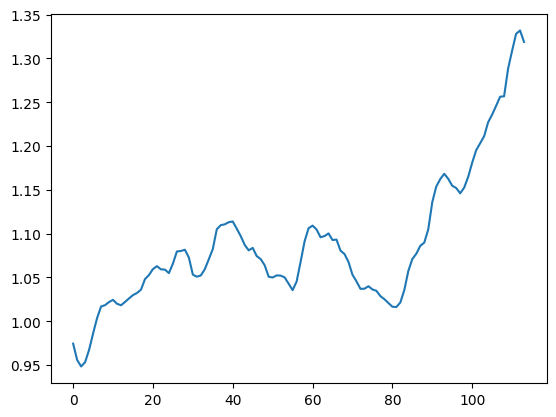

In [20]:
import matplotlib.pyplot as plt
plt.plot(cum_list)